## Investigating Fandango Movie Ratings

"In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest. Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars. Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars. Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis."

In [1]:
import pandas as pd
fandango_score_comparison = pd.read_csv('fandango_score_comparison.csv')
movie_ratings_16_17 = pd.read_csv('movie_ratings_16_17.csv')

In [2]:
fandango_score_comparison.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [3]:
movie_ratings_16_17.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


## Understanding The Data

In [4]:
fandango_previous = fandango_score_comparison[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 
                                                               'Fandango_votes','Fandango_Difference']].copy()
fandango_after = movie_ratings_16_17[['movie', 'year','fandango']].copy()


In [5]:
fandango_previous.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [6]:
fandango_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. The population of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — previous and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From Hickey's article and from the README.md of [the data set's repository](https://github.com/fivethirtyeight/data/tree/master/fandango), we can see that he used the following sampling criteria:

The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
The movie must have had tickets on sale in 2015.
The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the [data set's repository](https://github.com/mircealex/Movie_ratings_2016_17/blob/master/README.md)):

The movie must have been released in 2016 or later.
The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).
This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

## Changing the Goal of Our Analysis

At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

## Isolating the Samples We Need

With the new goal, we now have two populations that we want to describe and compare with each other:

- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.

<p>The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.</p>

Although one of the sampling criteria in our second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [7]:
fandango_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Above we used a value of 1 as the random seed. This is good practice because it suggests that we weren't trying out various random seeds just to get a favorable sample.

As of April 2018, these are the fan ratings we found:

|Movies | Fan Ratings |
|-------|-------------|
|Mechanic: Resurrection |2247 |
|Warcraft |7271 |
|Max Steel|493 |
|Me Before You | 5263|
|Fantastic Beasts and Where to Find Them |13400 |
|Cell | 17|
|Genius |127 |
|Sully |11877 |
|A Hologram for the King|500 |
|Captain America: Civil War | 35057|


90% of the movies in our sample are popular. This is enough and we move forward with a bit more confidence.

Let's also double-check the other data set for popular movies. The documentation states clearly that there're only movies with at least 30 fan ratings, but it should take only a couple of seconds to double-check here.

In [8]:
sum(fandango_previous['Fandango_votes'] < 30)

0

Let's start with Hickey's data set and isolate only the movies released in 2015. There's no special column for the releasing year, but we should be able to extract it from the strings in the FILM column.

In [9]:
fandango_previous['YEAR'] = fandango_previous['FILM'].str[-5:-1]
fandango_previous.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,YEAR
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


In [10]:
fandango_previous['YEAR'].value_counts()

2015    129
2014     17
Name: YEAR, dtype: int64

In [11]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [12]:
fandango_2015 = fandango_previous[fandango_previous['YEAR'] == '2015'].copy()
fandango_2015['YEAR'].value_counts()

2015    129
Name: YEAR, dtype: int64

In [13]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Comparing Distribution Shapes for 2015 and 2016

In [14]:
from numpy import arange
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

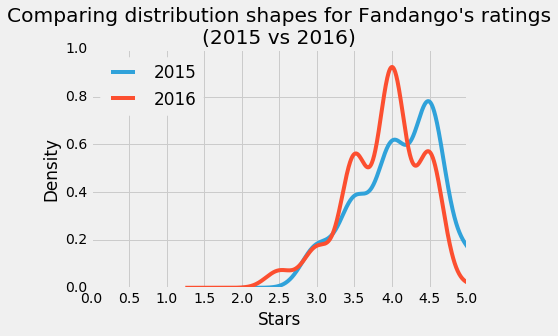

In [15]:
fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True)
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)")
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5.1, 0.5))
plt.show()


Two aspects are striking on the figure above:

Both distributions are strongly left skewed.
The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.
The left skew suggests that movies on Fandango are given mostly high and very high fan ratings.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

## Comparing Relative Frequencies

It seems we're following a good thread so far, but we need to analyze more granular information. Let's examine the frequency tables of the two distributions to analyze some numbers. Because the data sets have different numbers of movies, we normalize the tables and show percentages instead.

In [16]:
print('2015' + '\n' + '-' * 16)
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index()*100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [17]:
print('2016' + '\n' + '-' * 16)
fandango_2016['fandango'].value_counts(normalize = True).sort_index()*100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings(4.5 and 5) had significantly lower percentages compared to 2015. In 2016, under 1% of movies had 5 stars compared to 2015 where it was 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.



## Determining the Direction of the Change

In [18]:
f2015_mean = fandango_2015['Fandango_Stars'].mean()
f2016_mean = fandango_2016['fandango'].mean()

f2015_median = fandango_2015['Fandango_Stars'].median()
f2016_median = fandango_2016['fandango'].median()

f2015_mode = fandango_2015['Fandango_Stars'].mode()[0]
f2016_mode = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [f2015_mean, f2015_median, f2015_mode]
summary['2016'] = [f2016_mean, f2016_median, f2016_mode]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


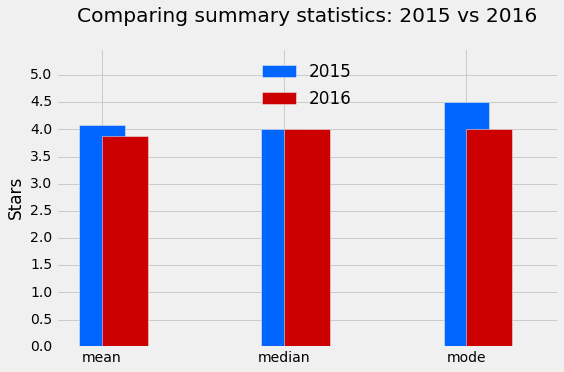

In [45]:
summary['2015'].plot.bar(color = '#0066FF' ,align = 'center', label = '2015', width = 0.25)
summary['2016'].plot.bar(color = '#CC0000' ,align = 'edge', label = '2016', width = 0.25, rot = 0,figsize=(8,5))
plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.ylabel('Stars')
plt.yticks(arange(0, 5.1, 0.5))
plt.legend(framealpha = 0, loc = 'upper center')





The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

## Conclusion
Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.